# Qualitative Evaluation & Filtering

This notebook filters the benchmark runs to retain only "complete" experiments.
A "complete" experiment is defined as a Parent Run (Algorithm x Dataset) where the number of successfully finished Child Runs equals the total number of series in that dataset.

This filtering step removes:
1. Interrupted runs (Global Timeouts).
2. Partial failures (where some series failed).
3. Superseded runs (if we select the latest complete one, though currently we just check for completeness).

In [1]:
import sys
import os
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Add current directory to path to import benchmark_db
current_dir = Path(os.getcwd())
if str(current_dir) not in sys.path:
    sys.path.append(str(current_dir))

from benchmark_db import BenchmarkDataManager

# Configuration
PROJECT_ROOT = Path("../")
MLFLOW_DB_PATH = PROJECT_ROOT / "results/mlflow_snapshot.db"
TRACKING_URI = f"sqlite:///{MLFLOW_DB_PATH}"

print(f"Tracking URI: {TRACKING_URI}")

db_manager = BenchmarkDataManager(TRACKING_URI, PROJECT_ROOT)

Tracking URI: sqlite:///../results/mlflow_snapshot.db


In [2]:
# Expected Number of Series per Dataset
EXPECTED_SERIES = {
    'actrectut': 2, 
    'has': 250, 
    'mocap': 9, 
    'pamap2': 9, 
    'skab': 34, 
    'tssb': 75, 
    'usc-had': 70, 
    'utsa': 32
}

print("Expected Series Counts:", EXPECTED_SERIES)

Expected Series Counts: {'actrectut': 2, 'has': 250, 'mocap': 9, 'pamap2': 9, 'skab': 34, 'tssb': 75, 'usc-had': 70, 'utsa': 32}


## 1. Fetch Parent Runs & Check Completeness

We fetch all parent runs for `default` (unsupervised) and `guided` (semi-supervised) modes.
We do not include `grid` search experiments yet.

In [3]:
# Get Experiment Names
experiment_map = db_manager.get_experiment_names_from_configs()

# Filter for non-grid experiments
target_modes = ['unsupervised', 'semi_supervised']
target_experiments = [experiment_map[m] for m in target_modes if m in experiment_map]

print(f"Target Experiments: {target_experiments}")

# Fetch Failure Analysis Data (contains Child Counts per Parent)
print("Fetching run stats...")
df_parents = db_manager.fetch_failure_analysis_sql(target_experiments)

# Normalize dataset names (lowercase) just in case
if not df_parents.empty:
    df_parents['dataset'] = df_parents['dataset'].str.lower()
    
print(f"Fetched {len(df_parents)} parent runs.")
display(df_parents.head())

Target Experiments: ['tsseg-experiment-unsupervised-12-12', 'tsseg-experiment-supervised-12-12']
Fetching run stats...


2026/01/22 09:37:16 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2026/01/22 09:37:16 INFO mlflow.store.db.utils: Updating database tables
2026/01/22 09:37:16 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/01/22 09:37:16 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2026/01/22 09:37:16 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/01/22 09:37:16 INFO alembic.runtime.migration: Will assume non-transactional DDL.


Fetched 451 parent runs.


,experiment_id,parent_id,start_time,parent_status,parent_duration_ms,algorithm,dataset,parent_error,run_name,total_children,children_finished,children_failed,child_oom,child_timeout,experiment_name,audit_status
0,11,7ba086e7a86948d6b3440dc99fbee808,1768814852400,FINISHED,11217779.0,hdp-hsmm-legacy,usc-had,,hdp-hsmm-legacy_usc-had_semi_supervised,70.0,70.0,0.0,0.0,0.0,tsseg-experiment-supervised-12-12,Complete
1,11,d9561563009945698381800e0e3403d1,1768814852122,FINISHED,436937.0,hdp-hsmm-legacy,mocap,,hdp-hsmm-legacy_mocap_semi_supervised,9.0,9.0,0.0,0.0,0.0,tsseg-experiment-supervised-12-12,Complete
2,11,9ceab2d4e7d14614b5b240b52d947326,1768814852122,FINISHED,254863.0,hdp-hsmm-legacy,actrectut,,hdp-hsmm-legacy_actrectut_semi_supervised,2.0,2.0,0.0,0.0,0.0,tsseg-experiment-supervised-12-12,Complete
3,11,4034f36ed86042ecb5279cd6253ae9d0,1768814852122,FINISHED,692521.0,hdp-hsmm-legacy,skab,,hdp-hsmm-legacy_skab_semi_supervised,34.0,34.0,0.0,0.0,0.0,tsseg-experiment-supervised-12-12,Complete
4,11,0707cf6bf44649d4b1506071bc9265df,1768814852121,FINISHED,336181.0,hdp-hsmm-legacy,tssb,,hdp-hsmm-legacy_tssb_semi_supervised,8.0,7.0,1.0,0.0,0.0,tsseg-experiment-supervised-12-12,Partial Failures


## 2. Apply Filter

Keep only parents where `children_finished` == `EXPECTED_SERIES[dataset]`.

In [4]:
# Whitelisted algorithms (keep even if incomplete)
whitelisted_algos = {'hdp-hsmm', 'ticc', 'hdp_hsmm'}
blacklisted_algos = {'vsax'}

def check_completeness(row):
    dataset = row['dataset']
    if dataset not in EXPECTED_SERIES:
        return False # Skip unknown datasets
    
    expected = EXPECTED_SERIES[dataset]
    return row['children_finished'] == expected

if not df_parents.empty:
    df_parents['is_complete'] = df_parents.apply(check_completeness, axis=1)
    
    # Filter: Keep Complete Runs OR Whitelisted Algorithms
    # We retain incomplete runs for whitelisted algorithms to allow partial analysis/imputation later.
    # Also apply Blacklist (e.g. VSAX)
    mask_valid = (df_parents['is_complete'] | df_parents['algorithm'].isin(whitelisted_algos)) & \
                 (~df_parents['algorithm'].isin(blacklisted_algos))
    
    valid_parents_all = df_parents[mask_valid].copy()
    incomplete_parents = df_parents[~mask_valid].copy()
    
    print(f"Total Parents: {len(df_parents)}")
    print(f"Valid Parents (Complete + Whitelisted - Blacklisted): {len(valid_parents_all)}")
    
    kept_incomplete = valid_parents_all[~valid_parents_all['is_complete']]
    if not kept_incomplete.empty:
        print(f"  -> Included {len(kept_incomplete)} incomplete runs from whitelist: {kept_incomplete['algorithm'].unique()}")
        
    print(f"Discarded (Incomplete & Non-Whitelisted or Blacklisted): {len(incomplete_parents)}")
    
    # --- Deduplication Strategy ---
    # We sort by start_time DESC and keep the first occurrence for each (Experiment, Dataset, Algorithm).
    # This ensures we analyze the latest attempt, ignoring older (superseded) runs.
    
    if 'start_time' in valid_parents_all.columns:
        valid_parents = valid_parents_all.sort_values('start_time', ascending=False) \
                                         .drop_duplicates(subset=['experiment_name', 'dataset', 'algorithm'], keep='first')
        
        dropped_count = len(valid_parents_all) - len(valid_parents)
        if dropped_count > 0:
            print(f"Dropped {dropped_count} older duplicate runs. Keeping latest.")
    else:
        valid_parents = valid_parents_all
        print("Warning: 'start_time' not found. Could not time-sort duplicates.")

    # Check for duplicates (should be 0 now)
    duplicates = valid_parents.groupby(['experiment_name', 'dataset', 'algorithm']).size()
    duplicates = duplicates[duplicates > 1]
    
    if not duplicates.empty:
        print(f"\nWarning: {len(duplicates)} combinations STILL have multiple complete runs.")
        display(duplicates.head())
    else:
        print("Deduplication successful. Unique (Exp, Dataset, Algo) triplets retained.")

else:
    print("No data found.")
    valid_parents = pd.DataFrame()

Total Parents: 451
Valid Parents (Complete + Whitelisted - Blacklisted): 332
  -> Included 10 incomplete runs from whitelist: ['ticc' 'hdp-hsmm']
Discarded (Incomplete & Non-Whitelisted or Blacklisted): 119
Deduplication successful. Unique (Exp, Dataset, Algo) triplets retained.


## 3. Visualization (Heatmap of Validated Series)

This heatmap shows the number of series for valid, complete experiments.
If a cell is present, it means we have a fully successful run for that Algorithm/Dataset combination.

Modes found: ['guided' 'default']

--- Mode: default ---


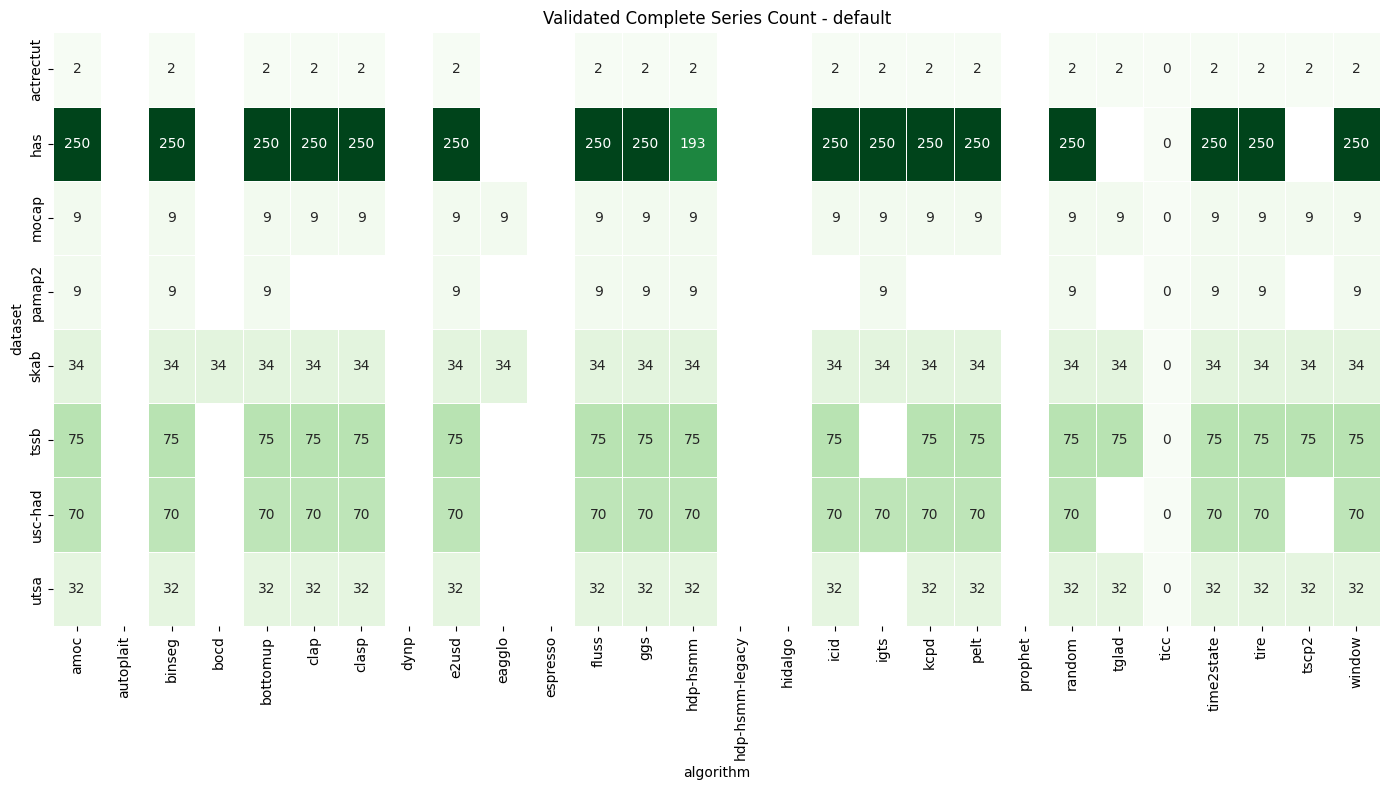


--- Mode: guided ---


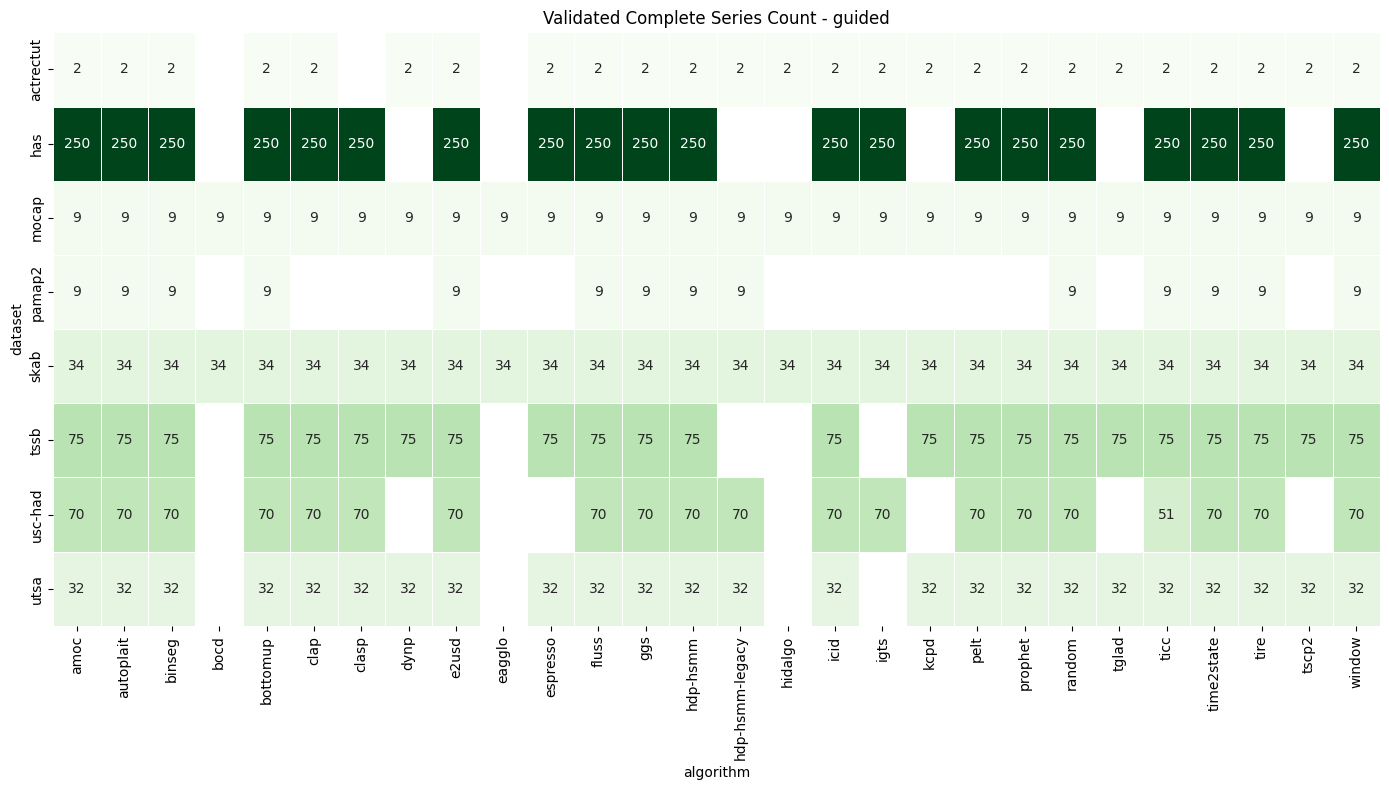

In [5]:
if not valid_parents.empty:
    # Fix: Ensure experiment_name is populated (handle int/str ID mismatch)
    if valid_parents['experiment_name'].isnull().any():
        print("Fixing missing experiment names...")
        import mlflow
        # Re-build map
        exp_map_config = db_manager.get_experiment_names_from_configs()
        target_exps = [exp_map_config[m] for m in ['unsupervised', 'semi_supervised'] if m in exp_map_config]
        
        mlflow_exps = [mlflow.get_experiment_by_name(n) for n in target_exps if mlflow.get_experiment_by_name(n)]
        id_map = {str(e.experiment_id): e.name for e in mlflow_exps}
        
        # Force ID to string for mapping
        valid_parents['experiment_name'] = valid_parents['experiment_name'].fillna(
            valid_parents['experiment_id'].astype(str).map(id_map)
        )

    # Helper to categorize mode
    def get_mode(exp_name):
        if not isinstance(exp_name, str): return 'unknown'
        # Exclude grid searches explicitly if they slipped through
        if 'grid' in exp_name: return 'grid_skipped'
        
        if 'unsupervised' in exp_name: return 'default'
        # 'supervised' catches 'semi_supervised' and 'supervised'
        if 'semi_supervised' in exp_name or 'guided' in exp_name or 'supervised' in exp_name: return 'guided'
        return 'other'

    valid_parents['mode'] = valid_parents['experiment_name'].apply(get_mode)
    
    print("Modes found:", valid_parents['mode'].unique())
    
    # Get all datasets/algos for consistent plotting
    all_datasets = sorted(EXPECTED_SERIES.keys())
    all_algos = sorted(valid_parents['algorithm'].unique())

    for mode in ['default', 'guided']:
        print(f"\n--- Mode: {mode} ---")
        subset = valid_parents[valid_parents['mode'] == mode]
        
        if subset.empty:
            print("No valid runs found.")
            continue
            
        # Pivot
        # We use 'max' for aggregation: if we have multiple complete runs (e.g. 2 runs of 250 series), 
        # we just want to show 250.
        pivot = subset.pivot_table(
            index='dataset', 
            columns='algorithm', 
            values='children_finished',
            aggfunc='max'
        )
        
        # Reindex to ensure all datasets are shown
        pivot = pivot.reindex(index=all_datasets, columns=all_algos)
        
        plt.figure(figsize=(14, 8))
        sns.heatmap(pivot, annot=True, fmt='.0f', cmap='Greens', cbar=False, linewidths=.5)
        plt.title(f"Validated Complete Series Count - {mode}")
        plt.tight_layout()
        plt.show()

## 4. Performance Analysis (Boxplots)

Now that we have identified the valid, complete experiments, we fetch the performance metrics for all their child runs.
We will visualize the distribution of metrics (e.g., F1-Score, Covering) for each Algorithm on each Dataset.

In [6]:
import benchmark_db
import importlib
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
from pathlib import Path

importlib.reload(benchmark_db)
from benchmark_db import BenchmarkDataManager

# Re-init manager
db_manager = BenchmarkDataManager(TRACKING_URI, PROJECT_ROOT)

# === PLOTTING HELPERS ===
def format_label(text, type='text'):
    """Formats text for plots (Axis labels, Legends, etc)."""
    if not isinstance(text, str): return text
    
    # 1. Metric Mappings
    metric_map = {
        'adjusted_mutual_info_score': 'AMI',
        'adjusted_rand_score': 'ARI',
        'covering_score': 'Covering Score',
        'covering_score_score': 'Covering Score',
        'f1_score': 'F1-Score',
        'f1_score_score': 'F1-Score', 
        'state_matching_score': 'State Matching Score',
        'state_matching_score_score': 'State Matching Score',
        'duration': 'Time (s)',
        'time': 'Time (s)',
    }
    
    if text.lower() in metric_map:
        return metric_map[text.lower()]
    
    # 2. Algorithm specific mappings
    if type == 'algo':
        return text.upper()
        
    # 3. General Text Capitalization
    return text.replace('_', ' ').title()

def save_fig(fig, filename, category):
    """Saves the current figure to ../figures/{category}/{filename}."""
    filename = filename.replace('score_score', 'score')
    
    base_dir = Path("../figures") / category
    os.makedirs(base_dir, exist_ok=True)
    
    path_pdf = base_dir / f"{filename}.pdf"
    path_png = base_dir / f"{filename}.png"
    
    try:
        fig.savefig(path_pdf, bbox_inches='tight', dpi=300)
        fig.savefig(path_png, bbox_inches='tight', dpi=150)
        print(f"Saved: {path_pdf}")
    except Exception as e:
        print(f"Error saving figure: {e}")

if not valid_parents.empty:

    print("Fetching metrics for valid parents (Strict Filtering Applied)...")
    parent_ids = valid_parents['parent_id'].tolist()
    
    # Fetch ALL metrics
    df_metrics = db_manager.fetch_child_metrics_sql(parent_ids, metrics=None)
    
    if not df_metrics.empty:
        print(f"Fetched {len(df_metrics)} metric records.")
        
        available_metrics = sorted(df_metrics['metric_name'].unique())
        
        # Merge with parent metadata
        df_merged = pd.merge(
            df_metrics, 
            valid_parents[['parent_id', 'experiment_name', 'dataset', 'algorithm', 'mode']], 
            on='parent_id', 
            how='left'
        )

        # --- Fair Comparison Filtering ---
        # Rule: Keep algorithm ONLY IF it has completed all datasets in 'required_datasets'
        # Exception: pamap2 is not required (too hard). 
        # Exception: manually whitelisted algorithms (ticc, hdp-hsmm) kept even if incomplete.
        
        required_datasets = set(EXPECTED_SERIES.keys()) - {'pamap2'}
        whitelisted_algos = {'hdp-hsmm', 'ticc', 'hdp_hsmm'} 
        blacklisted_algos = {'vsax'}

        # Check coverage of required datasets per algorithm
        algo_coverage = df_merged[df_merged['dataset'].isin(required_datasets)] \
                        .groupby('algorithm')['dataset'].unique().apply(set)
        
        kept_algos = []
        dropped_algos = []
        
        all_present_algos = sorted(df_merged['algorithm'].unique())
        
        for algo in all_present_algos:
            if algo in blacklisted_algos:
                dropped_algos.append(algo)
                continue

            covered_sets = algo_coverage.get(algo, set())
            
            # Condition: Covers all required OR is whitelisted
            if required_datasets.issubset(covered_sets) or algo in whitelisted_algos:
                kept_algos.append(algo)
            else:
                dropped_algos.append(algo)
        
        print(f"--- Fair Comparison Filter (Strict) ---")
        print(f"Required Datasets ({len(required_datasets)}): {sorted(required_datasets)}")
        print(f"Ignored (Too Hard): pamap2")
        print(f"Whitelisted (Close Enough): {whitelisted_algos}")
        print(f"Kept Algorithms ({len(kept_algos)}): {kept_algos}")
        print(f"Dropped Algorithms ({len(dropped_algos)}): {dropped_algos}")
        print("------------------------------\n")
        
        # Apply filter
        df_merged = df_merged[df_merged['algorithm'].isin(kept_algos)]
        
        # Pivot metrics to columns
        df_plot = df_merged.pivot_table(
            index=['parent_id', 'child_id', 'experiment_name', 'dataset', 'algorithm', 'mode'],
            columns='metric_name',
            values='metric_value'
        ).reset_index()
        
        # Determine available metrics in the pivot table
        metrics_in_df = [m for m in available_metrics if m in df_plot.columns]
        
        # Prepare lists for widgets
        all_algorithms = sorted(df_plot['algorithm'].unique())
        all_datasets = sorted(df_plot['dataset'].unique())
        
        # --- Interactive Visualization ---
        
        # Widgets
        w_mode = widgets.Dropdown(
            options=['default', 'guided'],
            value='default',
            description='Mode:',
            style={'description_width': 'initial'}
        )
        
        w_metric = widgets.Dropdown(
            options=metrics_in_df,
            value=metrics_in_df[0] if metrics_in_df else None,
            description='Metric:',
            style={'description_width': 'initial'}
        )
        
        w_agg = widgets.Dropdown(
            options=['Macro (Mean per Dataset)', 'Micro (All Runs)'],
            value='Macro (Mean per Dataset)',
            description='Aggregation:',
            style={'description_width': 'initial'}
        )
        
        w_dots = widgets.Checkbox(
            value=True,
            description='Show Dots'
        )

        w_random = widgets.Checkbox(
            value=True,
            description='Show Random'
        )

        w_datasets = widgets.SelectMultiple(
            options=all_datasets,
            value=tuple(all_datasets),
            description='Datasets:',
            rows=min(10, len(all_datasets)),
            style={'description_width': 'initial'}
        )

        out = widgets.Output()

        def plot_custom(change=None):
            mode = w_mode.value
            metric = w_metric.value
            selected_ds = w_datasets.value
            agg_type = w_agg.value
            show_dots = w_dots.value
            show_random = w_random.value
            
            with out:
                clear_output(wait=True)
                
                # Filter by Mode and Datasets
                mask = (df_plot['mode'] == mode) & (df_plot['dataset'].isin(selected_ds))
                data = df_plot[mask].copy()
                
                if data.empty:
                    print("No data found for the current selection.")
                    return
                
                if metric not in data.columns or data[metric].isna().all():
                    print(f"Metric '{metric}' contains no data for this selection.")
                    return
                
                # Prepare Aggregation
                if agg_type == 'Macro (Mean per Dataset)':
                    plot_data = data.groupby(['algorithm', 'dataset'])[metric].mean().reset_index()
                    title_suffix = ""
                else:
                    plot_data = data
                    title_suffix = "(All)"

                plot_data = plot_data.dropna(subset=[metric]).copy()

                if not show_random:
                     plot_data = plot_data[plot_data['algorithm'].str.lower() != 'random']

                if plot_data.empty:
                    print(f"No valid data points for metric '{metric}' after filtering.")
                    return
                
                plot_data['algo_label'] = plot_data['algorithm'].apply(lambda x: format_label(x, 'algo'))

                order = plot_data.groupby('algo_label')[metric].median().sort_values(ascending=False).index
                
                if len(order) == 0:
                    print("No algorithms to display.")
                    return

                # --- DYNAMIC WIDTH CALCULATION ---
                width_per_item = 0.35
                base_width = 1.6 
                n_items = len(order)
                
                calc_width = max(3.0, n_items * width_per_item + base_width)
                calc_height = 3.5

                fig, ax = plt.subplots(figsize=(calc_width, calc_height))
                
                sns.boxplot(data=plot_data, x='algo_label', y=metric, order=order, hue='algo_label', legend=False, palette='viridis', ax=ax)
                
                if show_dots:
                    # Swarmplot not suitable for large data, stripplot is safer
                    sns.stripplot(data=plot_data, x='algo_label', y=metric, order=order, hue='algo_label', legend=False, palette='dark:black', alpha=0.3, jitter=True, ax=ax)
                
                ax.set_ylabel(format_label(metric))
                ax.set_xlabel('')
                plt.xticks(rotation=45, ha='right')
                plt.grid(axis='y', linestyle='--', alpha=0.7, which="both")
                
                if 'time' in metric.lower() or 'duration' in metric.lower():
                    plt.yscale('log')
                elif plot_data[metric].max() <= 1.0 and plot_data[metric].min() >= -0.1:
                    plt.ylim(-0.05, 1.05)
                
                plt.tight_layout()
                plt.show()
                
                filename = f"boxplot_{mode}_{metric}"
                if len(selected_ds) < len(all_datasets):
                     ds_suffix = "_".join(sorted(selected_ds))
                     filename = f"{filename}_{ds_suffix}"
                     
                if not show_random:
                     filename += "_no_random"

                save_fig(fig, filename, "performance")

        w_mode.observe(plot_custom, names='value')
        w_metric.observe(plot_custom, names='value')
        w_datasets.observe(plot_custom, names='value')
        w_agg.observe(plot_custom, names='value')
        w_dots.observe(plot_custom, names='value')
        w_random.observe(plot_custom, names='value')

        ui = widgets.VBox([
            widgets.HBox([w_mode, w_metric, w_agg, w_dots, w_random]),
            widgets.Label("Select Datasets to Include:"),
            w_datasets,
            out
        ])
        
        plot_custom()
        display(ui)
                
    else:
        print("No metrics found for these parents.")
else:
    print("No valid parents to analyze (Strict Filter returned 0 results).")

Fetching metrics for valid parents (Strict Filtering Applied)...
Fetched 252633 metric records.
--- Fair Comparison Filter (Strict) ---
Required Datasets (7): ['actrectut', 'has', 'mocap', 'skab', 'tssb', 'usc-had', 'utsa']
Ignored (Too Hard): pamap2
Whitelisted (Close Enough): {'hdp_hsmm', 'hdp-hsmm', 'ticc'}
Kept Algorithms (19): ['amoc', 'autoplait', 'binseg', 'bottomup', 'clap', 'clasp', 'e2usd', 'fluss', 'ggs', 'hdp-hsmm', 'icid', 'kcpd', 'pelt', 'prophet', 'random', 'ticc', 'time2state', 'tire', 'window']
Dropped Algorithms (9): ['bocd', 'dynp', 'eagglo', 'espresso', 'hdp-hsmm-legacy', 'hidalgo', 'igts', 'tglad', 'tscp2']
------------------------------



In [7]:
# --- 5. Statistical Analysis (Critical Difference Diagrams) ---
from aeon.visualisation import plot_critical_difference
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_cd_diagram(change=None):
    mode = w_cd_mode.value
    metric = w_cd_metric.value
    
    with out_cd:
        clear_output(wait=True)
        
        # 1. Source Data
        source_df = None
        is_wide = False
        if 'df_plot' in globals() and not df_plot.empty:
            source_df = df_plot
            is_wide = True
            print("Using filtered data from Boxplot Analysis (df_plot).")
        elif 'df_merged' in globals() and not df_merged.empty:
            source_df = df_merged
            print("Using raw merged data (df_merged).")
        else:
            print("No data available. Run 'Performance Analysis' cell first.")
            return

        # Check metric direction
        lower_better = False
        if 'error' in metric.lower() or 'time' in metric.lower() or 'duration' in metric.lower():
            lower_better = True
        direction_str = "Lower is Better" if lower_better else "Higher is Better"

        # 2. Filter Data
        # Explicitly Exclude 'pamap2' (Hard constraint)
        if is_wide:
             if metric not in source_df.columns:
                 print(f"Error: Metric '{metric}' not found in columns.")
                 return
             mask = (source_df['mode'] == mode) & (source_df['dataset'] != 'pamap2')
             df_subset = source_df[mask].copy()
             # Map selected metric column to 'metric_value' for downstream compatibility
             df_subset['metric_value'] = df_subset[metric]
        else:
             mask = (source_df['mode'] == mode) & (source_df['metric_name'] == metric) & (source_df['dataset'] != 'pamap2')
             df_subset = source_df[mask].copy()
        
        if df_subset.empty:
            print(f"No data for Mode='{mode}' and Metric='{metric}'")
            return
            
        # 3. Create Unique Instance ID (Dataset + Series Index)
        # We using cumcount to order series relative to each other within (Dataset, Algo).
        df_subset.sort_values(['dataset', 'algorithm', 'child_id'], inplace=True)
        df_subset['series_idx'] = df_subset.groupby(['dataset', 'algorithm']).cumcount()
        df_subset['instance_id'] = df_subset['dataset'] + "_" + df_subset['series_idx'].astype(str)
        
        # 4. Pivot: Rows=Instances, Cols=Algorithms
        df_wide = df_subset.pivot(index='instance_id', columns='algorithm', values='metric_value')
        
        # --- FIX: Filter out incompatible algorithms (All NaNs for this metric) ---
        # e.g. Changes Point algorithms (pelt, amoc) don't have State metrics (ARI), so they appear as All-NaNs.
        # We must drop them BEFORE imputation to prevent filling them with 0.0.
        nan_cols = df_wide.columns[df_wide.isna().all()]
        if len(nan_cols) > 0:
            print(f"Dropping incompatible algorithms (All NaNs for {metric}): {list(nan_cols)}")
            df_wide = df_wide.drop(columns=nan_cols)
        
        if df_wide.empty:
            print("No algorithms remaining with valid data for this metric.")
            return

        # 5. Handle Missing Data (Imputation: Dataset Mean)
        # Whitelisted algorithms (ticc, hdp-hsmm) may have simpler coverage.
        # We impute missing values with the AVERAGE score of that algorithm on the SAME dataset.
        
        missing_counts = df_wide.isnull().sum()
        total_missing = missing_counts.sum()
        
        if total_missing > 0:
            print(f"\n--- Handling Missing Data (Imputation by Dataset Mean) ---")
            print(f"Total Missing Instances: {total_missing}")
            print(f"Missing per algo:")
            print(missing_counts[missing_counts > 0])
            
            # Helper: Extract dataset name from index "dataset_seriesidx"
            # We assume split on LAST underscore gives "dataset" and "idx"
            instance_datasets = df_wide.index.to_series().apply(lambda x: x.rsplit('_', 1)[0])
            
            # Impute
            for col in df_wide.columns:
                if df_wide[col].isna().any():
                     # Computes mean of 'col' grouped by 'dataset', then broadcasts back to original index
                     dataset_means = df_wide[col].groupby(instance_datasets).transform('mean')
                     df_wide[col] = df_wide[col].fillna(dataset_means)
            
            # Fallback (e.g., if an algo is missing for an ENTIRE dataset)
            remaining = df_wide.isna().sum().sum()
            if remaining > 0:
                 print(f"Warning: {remaining} values still NaN (Whole dataset missing?). Filling with Worst Case.")
                 fill_val = df_wide.max().max() * 1.2 if lower_better else 0.0
                 df_wide = df_wide.fillna(fill_val)
            else:
                 print("Imputation successful using dataset means.")
        
        print(f"\n--- Analysis ---")
        print(f"Comparing {len(df_wide.columns)} algorithms on {len(df_wide)} instances.")

        # Check Rankings (Diagnostic)
        # Fix: Show BEST algorithms first.
        # If lower_better=True (Error), asc=True (Smallest is best)
        # If lower_better=False (Score), asc=False (Largest is best)
        means = df_wide.mean().sort_values(ascending=lower_better)
        print(f"\nTop 5 Algorithms (Mean {metric}):")
        for i, (alg, score) in enumerate(means.head(5).items(), 1):
             print(f"{i}. {alg}: {score:.4f}")
        
        # 6. Plot
        scores_array = df_wide.values
        # --- FORMAT LABELS ---
        labels = [format_label(l, 'algo') for l in df_wide.columns.tolist()]
        
        try:
            # We must use a new figure context for save_fig to work reliably
            
            fig, ax = plot_critical_difference(scores_array, labels, lower_better=lower_better)
            
            # Optimize Size: Fit in Single Column (approx 6-8 inch width for readability)
            # CD Diagrams are wide. 
            fig.set_size_inches(6, 3) 
            
            # No Title as requested
            # plt.title(...)
            
            save_fig(fig, f"cd_diagram_{mode}_{metric}", "cd_diagrams")
            plt.show()
            
        except Exception as e:
            # Fallback if return value isn't fig, ax in this version
            try:
                plot_critical_difference(scores_array, labels, lower_better=lower_better)
                fig = plt.gcf()
                fig.set_size_inches(6, 3)
                save_fig(fig, f"cd_diagram_{mode}_{metric}", "cd_diagrams")
                plt.show()
            except Exception as e2:
                 print(f"Error plotting CD diagram: {e} | {e2}")

# Widgets
if 'df_plot' in locals() and not df_plot.empty:
    # Use metrics from df_plot if possible
    meta_cols = {'parent_id', 'child_id', 'experiment_name', 'dataset', 'algorithm', 'mode'}
    avail_metrics = sorted([c for c in df_plot.columns if c not in meta_cols and pd.api.types.is_numeric_dtype(df_plot[c])])
else:
    if 'df_merged' in locals():
        avail_metrics = sorted(df_merged['metric_name'].unique())
    else:
        avail_metrics = []

if avail_metrics:
    w_cd_mode = widgets.Dropdown(options=['default', 'guided'], value='default', description='Mode:')
    w_cd_metric = widgets.Dropdown(options=avail_metrics, value='covering_score' if 'covering_score' in avail_metrics else avail_metrics[0], description='Metric:')
    
    out_cd = widgets.Output()
    
    w_cd_mode.observe(plot_cd_diagram, names='value')
    w_cd_metric.observe(plot_cd_diagram, names='value')
    
    # Run once
    with out_cd:
        plot_cd_diagram()
        
    display(widgets.VBox([widgets.HBox([w_cd_mode, w_cd_metric]), out_cd]))
else:
    print("Please run the 'Performance Analysis' cell above to load data.")

In [8]:
# --- DEBUG: CHECK SPECIFIC ALGO/DATASET ---
d_algo = 'fluss'
d_data = 'tssb'
d_metric = 'covering_score'

print(f"=== Debugging Specific Case: {d_algo} on {d_data} ===")

# 1. Check what is currently plotted (df_plot)
if 'df_plot' in locals() and not df_plot.empty:
    print("\n[1] Checking df_plot (Data used for visualizations):")
    subset_plot = df_plot[
        (df_plot['algorithm'] == d_algo) & 
        (df_plot['dataset'] == d_data)
    ]
    if subset_plot.empty:
        print(" -> No data found in df_plot for this combination.")
    else:
        print(f" -> Found {len(subset_plot)} child runs (series).")
        if d_metric in subset_plot.columns:
            mean_val = subset_plot[d_metric].mean()
            print(f" -> Mean {d_metric}: {mean_val:.4f}")
        else:
             print(f" -> Metric '{d_metric}' not found. Available keys: {sorted(subset_plot.columns)}")
else:
    print("\n[1] df_plot is not defined or empty.")

# 2. Check the Parent Selection (valid_parents) used to fetch this data
if 'valid_parents' in locals() and not valid_parents.empty:
    print("\n[2] Checking valid_parents (The list of parents considered 'Complete' & 'Latest'):")
    subset_parents = valid_parents[
        (valid_parents['algorithm'] == d_algo) & 
        (valid_parents['dataset'] == d_data)
    ]
    
    if subset_parents.empty:
        print(" -> No VALID parent found. This explains why it is missing from plots.")
    else:
        # Convert date for display
        subset_parents = subset_parents.copy()
        if 'start_time' in subset_parents.columns:
            subset_parents['start_date'] = pd.to_datetime(subset_parents['start_time'], unit='ms', utc=True)
            
        print(f" -> Found {len(subset_parents)} VALID parents selected.")
        cols = ['experiment_name', 'dataset', 'algorithm', 'start_date', 'children_finished', 'parent_id']
        display(subset_parents[[c for c in cols if c in subset_parents.columns]])
        
else:
    print("\n[2] valid_parents is not defined.")

# 3. Check Raw Parents (To see if a newer run EXSISTS but was discarded)
if 'df_parents' in locals() and not df_parents.empty:
    print("\n[3] Checking df_parents (RAW list before completeness filter):")
    raw_subset = df_parents[
        (df_parents['algorithm'] == d_algo) & 
        (df_parents['dataset'] == d_data)
    ]
    
    if raw_subset.empty:
        print(" -> No parents found even in raw fetch.")
    else:
        raw_subset = raw_subset.copy()
        if 'start_time' in raw_subset.columns:
            raw_subset['start_date'] = pd.to_datetime(raw_subset['start_time'], unit='ms', utc=True)
        
        # --- Fetch Scores for ALL attempts to compare ---
        p_ids = raw_subset['parent_id'].tolist()
        print(f" -> Fetching '{d_metric}' for {len(p_ids)} historical runs to compare...")
        
        try:
             # Fetch metrics for these parents specificially for this debug view
             df_debug_metrics = db_manager.fetch_child_metrics_sql(p_ids, metrics=[d_metric])
             
             if not df_debug_metrics.empty and d_metric in df_debug_metrics['metric_name'].values:
                 # Calculate mean score per parent
                 scores = df_debug_metrics[df_debug_metrics['metric_name'] == d_metric].groupby('parent_id')['metric_value'].mean().reset_index()
                 scores.rename(columns={'metric_value': f'mean_{d_metric}'}, inplace=True)
                 
                 # Merge back to raw_subset
                 raw_subset = pd.merge(raw_subset, scores, on='parent_id', how='left')
             else:
                 print(f" -> Warning: No metric values found for '{d_metric}'.")
                 raw_subset[f'mean_{d_metric}'] = np.nan
                 
        except Exception as e:
            print(f" -> Could not fetch metrics (Error: {e})")

        print(f" -> Found {len(raw_subset)} total attempts (History).")
        
        # Display Columns
        cols = ['experiment_name', 'start_date', 'children_finished', 'is_complete', f'mean_{d_metric}', 'parent_id']
        show_cols = [c for c in cols if c in raw_subset.columns]
        
        # Sort so latest is top
        sorted_raw = raw_subset[show_cols].sort_values('start_date', ascending=False)
        display(sorted_raw.head(10))
        
        # --- [4] Inspect Children of LATEST Parent ---
        latest_parent_row = sorted_raw.iloc[0]
        latest_parent_id = latest_parent_row['parent_id']
        latest_date = latest_parent_row['start_date']
        
        print(f"\n[4] 🔎 Inspecting Children of LATEST Parent ({latest_date})")
        print(f"    Parent ID: {latest_parent_id}")
        
        q_children_details = f"""
        SELECT 
            r.run_uuid as child_id,
            r.status,
            r.start_time,
            m.value as {d_metric}
        FROM runs r
        JOIN tags t_parent ON r.run_uuid = t_parent.run_uuid AND t_parent.key = 'mlflow.parentRunId'
        LEFT JOIN metrics m ON r.run_uuid = m.run_uuid AND m.key = '{d_metric}'
        WHERE t_parent.value = '{latest_parent_id}'
        """
        
        conn = db_manager.get_sqlite_connection()
        try:
            df_children_debug = pd.read_sql_query(q_children_details, conn)
            if not df_children_debug.empty:
                # Convert date
                if 'start_time' in df_children_debug.columns:
                    df_children_debug['start_date'] = pd.to_datetime(df_children_debug['start_time'], unit='ms', utc=True)
                
                print(f" -> Found {len(df_children_debug)} child runs.")
                display(df_children_debug[['child_id', 'start_date', 'status', d_metric]].sort_values('start_date'))
            else:
                print(" -> No children found for this parent.")
        finally:
            conn.close()

=== Debugging Specific Case: fluss on tssb ===

[1] Checking df_plot (Data used for visualizations):
 -> Found 150 child runs (series).
 -> Mean covering_score: 0.6604

[2] Checking valid_parents (The list of parents considered 'Complete' & 'Latest'):
 -> Found 2 VALID parents selected.


,experiment_name,dataset,algorithm,start_date,children_finished,parent_id
17,tsseg-experiment-supervised-12-12,tssb,fluss,2026-01-16 15:54:10.768000+00:00,75.0,a141e54e41d0411495a4023d4c4db13f
370,tsseg-experiment-unsupervised-12-12,tssb,fluss,2025-12-12 18:30:13.980000+00:00,75.0,13c384cdf1564e9ab857f7cff57a21e0



[3] Checking df_parents (RAW list before completeness filter):
 -> Fetching 'covering_score' for 2 historical runs to compare...
 -> Found 2 total attempts (History).


,experiment_name,start_date,children_finished,is_complete,mean_covering_score,parent_id
0,tsseg-experiment-supervised-12-12,2026-01-16 15:54:10.768000+00:00,75.0,True,0.700893,a141e54e41d0411495a4023d4c4db13f
1,tsseg-experiment-unsupervised-12-12,2025-12-12 18:30:13.980000+00:00,75.0,True,0.620004,13c384cdf1564e9ab857f7cff57a21e0



[4] 🔎 Inspecting Children of LATEST Parent (2026-01-16 15:54:10.768000+00:00)
    Parent ID: a141e54e41d0411495a4023d4c4db13f
 -> Found 75 child runs.


,child_id,start_date,status,covering_score
1,02257a709ce14e5ebb8e627872145431,2026-01-16 15:55:26.599000+00:00,FINISHED,0.970755
57,c6d6b1a4a9ef426db5069ea2002a3379,2026-01-16 15:55:55.797000+00:00,FINISHED,0.994702
8,1a0a3216ba864b4ab4a22066faeedece,2026-01-16 15:55:58.882000+00:00,FINISHED,0.891026
9,1ca4ffd3403c4dd4accf3203c24de8ac,2026-01-16 15:56:01.938000+00:00,FINISHED,0.967709
43,9ed643b6f291466f974c9e3c1057af95,2026-01-16 15:56:04.980000+00:00,FINISHED,0.478078
...,...,...,...,...
25,4fd9a1bc173b42e38dfe9ec8ec45a203,2026-01-16 15:59:38.096000+00:00,FINISHED,0.394251
13,262a321554284d478241ab1cce86bbe2,2026-01-16 15:59:41.359000+00:00,FINISHED,0.587997
51,b0c2d5c2796e47b99ed24946bd98efc0,2026-01-16 15:59:45.509000+00:00,FINISHED,0.601632
24,45f1902bdc214d83bac72d0a318eafed,2026-01-16 15:59:48.626000+00:00,FINISHED,0.819100


In [9]:
if 'df_plot' in locals() and not df_plot.empty:
    print("--- Metric Comparison Scatterplot ---")
    
    # 1. Categorize Metrics
    # Heuristic: Name contains 'f1' or 'covering' -> Change Point (CP)
    #            Else -> State Detection
    
    # Try to reuse metrics_in_df if available, else derive
    try:
        current_metrics = metrics_in_df
    except NameError:
        meta_cols = {'parent_id', 'child_id', 'experiment_name', 'dataset', 'algorithm', 'mode'}
        current_metrics = [c for c in df_plot.columns if c not in meta_cols and pd.api.types.is_numeric_dtype(df_plot[c])]

    cp_metrics = sorted([m for m in current_metrics if 'f1' in m.lower() or 'covering' in m.lower()])
    state_metrics = sorted([m for m in current_metrics if m not in cp_metrics])
    
    if not cp_metrics: cp_metrics = current_metrics # Fallback
    if not state_metrics: state_metrics = current_metrics # Fallback

    # 2. Widgets
    w_sc_mode = widgets.Dropdown(
        options=['default', 'guided'],
        value='default',
        description='Mode:'
    )
    
    w_sc_agg = widgets.Dropdown(
        options=['Macro (Mean per Dataset)', 'Micro (All Runs)'],
        value='Macro (Mean per Dataset)',
        description='Agg:'
    )
    
    w_sc_x = widgets.Dropdown(
        options=cp_metrics,
        value=cp_metrics[0] if cp_metrics else None,
        description='CP (X):'
    )
    
    w_sc_y = widgets.Dropdown(
        options=state_metrics,
        value=state_metrics[0] if state_metrics else None,
        description='State (Y):'
    )

    if 'all_datasets' not in locals():
        all_datasets = sorted(df_plot['dataset'].unique())

    w_sc_ds = widgets.SelectMultiple(
        options=all_datasets,
        value=tuple(all_datasets),
        description='Datasets:',
        rows=6
    )

    out_sc = widgets.Output()

    def plot_scatter(change=None):
        mode = w_sc_mode.value
        agg = w_sc_agg.value
        x_metric = w_sc_x.value
        y_metric = w_sc_y.value
        sel_ds = w_sc_ds.value
        
        with out_sc:
            clear_output(wait=True)
            
            if not x_metric or not y_metric:
                print("Please select metrics.")
                return
            
            mask = (df_plot['mode'] == mode) & (df_plot['dataset'].isin(sel_ds))
            data = df_plot[mask].copy()
            
            if data.empty:
                print("No data for current selection.")
                return
            
            if x_metric not in data.columns or y_metric not in data.columns:
                print(f"Metrics not found in dataframe.")
                return

            data = data.dropna(subset=[x_metric, y_metric])
            
            if data.empty:
                print(f"No valid data points found.")
                return
            
            # FORMAT ALGO
            data['algo_label'] = data['algorithm'].apply(lambda x: format_label(x, 'algo'))

            if 'Macro' in agg:
                plot_data = data.groupby(['algo_label', 'dataset'])[[x_metric, y_metric]].mean().reset_index()
                title_suffix = ""
                style_var = 'dataset'
                alpha_val = 0.8
            else:
                plot_data = data
                title_suffix = "(All Runs)"
                style_var = 'dataset'
                alpha_val = 0.5
            
            # Compact Square Figure
            fig, ax = plt.subplots(figsize=(6, 5))
            
            sns.scatterplot(
                data=plot_data,
                x=x_metric,
                y=y_metric,
                hue='algo_label',
                style=style_var if agg == 'Macro (Mean per Dataset)' or len(plot_data) < 200 else None, 
                palette='viridis',
                s=100,
                alpha=alpha_val,
                ax=ax
            )
            
            # plt.title(f"{format_label(x_metric)} vs {format_label(y_metric)} - {mode}\n{title_suffix}")
            ax.set_xlabel(format_label(x_metric))
            ax.set_ylabel(format_label(y_metric))
            # Legend
            if ax.get_legend():
                ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, title='Algorithm / Dataset')
            
            if 'time' in x_metric.lower() or 'duration' in x_metric.lower():
                plt.xscale('log')
            if 'time' in y_metric.lower() or 'duration' in y_metric.lower():
                plt.yscale('log')
                
            plt.grid(True, linestyle='--', alpha=0.5, which='both')
            
            plt.tight_layout()
            plt.show()
            
            filename = f"scatter_{mode}_{x_metric}_{y_metric}"
            if len(sel_ds) < len(all_datasets):
                ds_suffix = "_".join(sorted(sel_ds))
                filename = f"{filename}_{ds_suffix}"
            
            save_fig(fig, filename, "comparisons")

    w_sc_mode.observe(plot_scatter, names='value')
    w_sc_agg.observe(plot_scatter, names='value')
    w_sc_x.observe(plot_scatter, names='value')
    w_sc_y.observe(plot_scatter, names='value')
    w_sc_ds.observe(plot_scatter, names='value')

    plot_scatter()
    
    display(widgets.VBox([
        widgets.HBox([w_sc_mode, w_sc_agg]),
        widgets.HBox([w_sc_x, w_sc_y]),
        widgets.Label("Datasets to Include:"),
        w_sc_ds,
        out_sc
    ]))
else:
    print("Metric dataframe not loaded. Run the cell above first.")

--- Metric Comparison Scatterplot ---


In [10]:
# --- 5. Grid Search Optimization Analysis ---
# "Best-of-Grid" Extraction: The single best configuration per (Algo, Dataset)
# derived from Grid Search experiments.

def fetch_best_grid_results(metric_to_optimize='covering_score'):
    """
    Fetches Grid Search results and keeps the best run 
    per (Algo, Dataset) according to the chosen metric.
    """
    print(f"Extracting Best Grid Results (Optimization Metric: {metric_to_optimize})...")
    
    # 1. Identify Grid Experiments
    grid_exps = [name for name in experiment_map.values() if 'grid' in name]
    print(f"Grid Experiments identified: {len(grid_exps)}")
    
    if not grid_exps:
        print("No grid experiment found.")
        return pd.DataFrame()

    # 2. Fetch stats to check completeness
    df_grid_stats = db_manager.fetch_failure_analysis_sql(grid_exps)
    
    if df_grid_stats.empty:
        print("No grid stats found.")
        return pd.DataFrame()

    df_grid_stats['dataset'] = df_grid_stats['dataset'].str.lower()
    df_grid_stats['is_complete'] = df_grid_stats.apply(check_completeness, axis=1)
    
    # MODIFICATION: Keep anything that produced children results (children_finished > 0)
    valid_grids = df_grid_stats[df_grid_stats['children_finished'] > 0].copy()
    
    if valid_grids.empty:
        print("No valid grid run with finished children found.")
        return pd.DataFrame()
        
    print(f"Grid Parents considered (with data): {len(valid_grids)}")
    
    # 3. Fetch metrics for these parents
    parent_ids = valid_grids['parent_id'].tolist()
    df_metrics = db_manager.fetch_child_metrics_sql(parent_ids, metrics=None)
    
    if df_metrics.empty:
        print("No metrics found for grid runs.")
        return pd.DataFrame()

    # Merge with metadata
    df_full = pd.merge(
        df_metrics,
        valid_grids[['parent_id', 'experiment_name', 'dataset', 'algorithm']],
        on='parent_id'
    )
    
    # Distinguish Grid Modes (Default/Unsupervised vs Guided/Supervised)
    def get_grid_mode(exp_name):
        name = str(exp_name).lower()
        if 'unsupervised' in name: return 'grid_default'
        if 'semi_supervised' in name or 'guided' in name or 'supervised' in name: return 'grid_guided'
        return 'grid_unknown'

    df_full['mode'] = df_full['experiment_name'].apply(get_grid_mode)
    print("Grid Modes found:", df_full['mode'].unique())

    # Check metric availability
    available_metrics = df_full['metric_name'].unique()
    if metric_to_optimize not in available_metrics:
        # Try to find a fallback with '_score' suffix
        alt_metric = f"{metric_to_optimize}_score"
        if alt_metric in available_metrics:
            print(f"Metric '{metric_to_optimize}' not found. Switching to '{alt_metric}'.")
            metric_to_optimize = alt_metric
        else:
            print(f"Metric '{metric_to_optimize}' not found in grid results.")
            print(f"Available metrics: {list(available_metrics)}")
            return pd.DataFrame()

    # 4. Filter on optimization metric to find Best Parent ID
    # Aggregation: Mean score on children for the parent (Config)
    # Group by (Algo, Dataset, MODE) to keep separate bests for supervised/unsupervised
    df_scores = df_full[df_full['metric_name'] == metric_to_optimize].groupby(
        ['parent_id', 'dataset', 'algorithm', 'mode']
    )['metric_value'].mean().reset_index()
    
    if df_scores.empty:
        print(f"Metric '{metric_to_optimize}' produced empty scores.")
        return pd.DataFrame()

    # 5. Select Best Parent per (Algo, Dataset, Mode)
    idx_best = df_scores.groupby(['algorithm', 'dataset', 'mode'])['metric_value'].idxmax()
    best_parents_df = df_scores.loc[idx_best]
    
    best_parent_ids = best_parents_df['parent_id'].unique()
    print(f"Identified {len(best_parent_ids)} optimal configurations.")
    
    # 6. Retrieve ALL metrics for these best parents
    final_df = df_full[df_full['parent_id'].isin(best_parent_ids)].copy()
    # Note: 'mode' is already correct from earlier step
    
    return final_df

# Execution
# Default target
target_metric = 'covering_score'

# Check existence in previous non-grid results (df_plot)
if 'df_plot' in locals() and not df_plot.empty:
    cols = df_plot.columns
    if target_metric not in cols:
        cov_metrics = [c for c in cols if 'covering' in c]
        if cov_metrics:
            target_metric = cov_metrics[0]
        elif 'f1_score_score' in cols:
             target_metric = 'f1_score_score'
        elif 'f1_score' in cols:
            target_metric = 'f1_score'

df_grid_best = fetch_best_grid_results(metric_to_optimize=target_metric)

if not df_grid_best.empty:
    print("\nExample of optimal results (Best Grid):")
    display(df_grid_best.head())

Extracting Best Grid Results (Optimization Metric: covering_score)...
Grid Experiments identified: 2
Grid Parents considered (with data): 3570
Grid Modes found: ['grid_default' 'grid_guided']
Identified 342 optimal configurations.

Example of optimal results (Best Grid):


,parent_id,child_id,metric_name,metric_value,experiment_name,dataset,algorithm,mode
12,d03dbc9b26c64f42a3e6926c39acdc5b,00003b21628f4c9a80f7ecda65fcfd30,f1_score_score,0.0,tsseg-experiment-grid-unsupervised-12-12,tssb,binseg,grid_default
13,d03dbc9b26c64f42a3e6926c39acdc5b,00003b21628f4c9a80f7ecda65fcfd30,f1_score_precision,0.0,tsseg-experiment-grid-unsupervised-12-12,tssb,binseg,grid_default
14,d03dbc9b26c64f42a3e6926c39acdc5b,00003b21628f4c9a80f7ecda65fcfd30,f1_score_recall,0.0,tsseg-experiment-grid-unsupervised-12-12,tssb,binseg,grid_default
15,d03dbc9b26c64f42a3e6926c39acdc5b,00003b21628f4c9a80f7ecda65fcfd30,gaussian_f1_score,0.0,tsseg-experiment-grid-unsupervised-12-12,tssb,binseg,grid_default
16,d03dbc9b26c64f42a3e6926c39acdc5b,00003b21628f4c9a80f7ecda65fcfd30,gaussian_f1_precision,0.0,tsseg-experiment-grid-unsupervised-12-12,tssb,binseg,grid_default


In [11]:
# --- 5b. Aligned Tuning Gain Analysis (Intersection of Valid Series) ---
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

# Helper to fetch LAX non-grid data (includes incomplete runs)
def fetch_lax_non_grid_data():
    """
    Fetches non-grid metrics but WITHOUT the strict completeness filter.
    (Matches logic requested: keep partial runs to compare intersection with grid).
    """
    print("Fetching LAX non-grid data (including incomplete runs)...")
    # Reuse df_parents from Section 1 (Raw parents list)
    if 'df_parents' not in globals() or df_parents.empty:
        print("df_parents not found. Run section 1.")
        return pd.DataFrame()

    # 1. Apply LAX Filter (Only remove Blacklisted)
    blacklisted = {'vsax'}
    mask = ~df_parents['algorithm'].isin(blacklisted)
    lax_parents_all = df_parents[mask].copy()

    # 2. De-duplicate (Keep latest)
    if 'start_time' in lax_parents_all.columns:
        lax_parents = lax_parents_all.sort_values('start_time', ascending=False) \
                                     .drop_duplicates(subset=['experiment_name', 'dataset', 'algorithm'], keep='first')
        print(f"Lax Parents: {len(lax_parents)} (Dropped {len(lax_parents_all) - len(lax_parents)} duplicates)")
    else:
        lax_parents = lax_parents_all

    # 3. Add 'mode' column
    def get_mode_lax(exp_name):
        if not isinstance(exp_name, str): return 'unknown'
        if 'grid' in exp_name: return 'grid_skipped' # Should not happen based on sec 1
        if 'unsupervised' in exp_name: return 'default'
        if 'semi_supervised' in exp_name or 'guided' in exp_name or 'supervised' in exp_name: return 'guided'
        return 'other'
    
    lax_parents['mode'] = lax_parents['experiment_name'].apply(get_mode_lax)

    # 4. Fetch Metrics
    p_ids = lax_parents['parent_id'].tolist()
    if not p_ids:
        return pd.DataFrame()
        
    df_lax_metrics = db_manager.fetch_child_metrics_sql(p_ids, metrics=None)
    
    if df_lax_metrics.empty:
        return pd.DataFrame()

    # 5. Merge
    df_lax_full = pd.merge(
        df_lax_metrics, 
        lax_parents[['parent_id', 'experiment_name', 'dataset', 'algorithm', 'mode']], 
        on='parent_id', 
        how='left'
    )
    
    return df_lax_full

# Cache this data to avoid re-fetching constantly
if 'df_lax_non_grid' not in globals():
    df_lax_non_grid = fetch_lax_non_grid_data()
else:
    print("Using cached df_lax_non_grid.")


def get_aligned_data(df_non_grid, df_grid, metric_name):
    """
    Aligns Non-Grid (Default/Guided) and Grid results on the exact same (Dataset, Series Index).
    """
    # 1. Prepare Non-Grid Data
    if df_non_grid is None or df_non_grid.empty:
        return pd.DataFrame()
    
    if metric_name not in df_non_grid['metric_name'].values:
        # Check if pivoted
        if metric_name in df_non_grid.columns:
            # It's pivoted (like df_plot) - Handle?
            # Ideally strict input format. Assume Long format from fetch_lax_non_grid_data
            pass
        else:
            return pd.DataFrame()
            
    # Filter for metric (Long format assumed)
    cols = ['algorithm', 'dataset', 'mode', 'child_id', 'metric_value']
    
    # Check format
    if 'metric_name' in df_non_grid.columns:
        df_ng = df_non_grid[df_non_grid['metric_name'] == metric_name][cols].copy()
    else:
        # Wide format fallback
        cols_wide = ['algorithm', 'dataset', 'mode', 'child_id', metric_name]
        df_ng = df_non_grid[cols_wide].copy()
        df_ng.rename(columns={metric_name: 'metric_value'}, inplace=True)
        
    df_ng = df_ng.dropna(subset=['metric_value'])
    
    # Generate Series Index 
    df_ng = df_ng.sort_values(['algorithm', 'dataset', 'mode', 'child_id'])
    df_ng['series_idx'] = df_ng.groupby(['algorithm', 'dataset', 'mode']).cumcount()
    
    # 2. Prepare Grid Data
    if df_grid is None or df_grid.empty:
        return pd.DataFrame()
        
    df_g = df_grid[df_grid['metric_name'] == metric_name].copy()
    if df_g.empty:
        return pd.DataFrame()
        
    df_g = df_g.dropna(subset=['metric_value'])
    cols_grid = ['algorithm', 'dataset', 'mode', 'child_id', 'metric_value']
    df_g = df_g[cols_grid].copy()
    
    # Generate Series Index for Grid
    df_g = df_g.sort_values(['algorithm', 'dataset', 'mode', 'child_id'])
    df_g['series_idx'] = df_g.groupby(['algorithm', 'dataset', 'mode']).cumcount()
    
    # 3. Perform Alignment per Algorithm/Dataset
    aligned_frames = []
    pairs = df_ng[['algorithm', 'dataset']].drop_duplicates().values
    
    for algo, ds in pairs:
        # Default
        ng_def = df_ng[(df_ng['algorithm'] == algo) & (df_ng['dataset'] == ds) & (df_ng['mode'] == 'default')]
        g_def = df_g[(df_g['algorithm'] == algo) & (df_g['dataset'] == ds) & (df_g['mode'] == 'grid_default')]
        
        if not ng_def.empty and not g_def.empty:
            common_idx = np.intersect1d(ng_def['series_idx'], g_def['series_idx'])
            if len(common_idx) > 0:
                aligned_frames.append(ng_def[ng_def['series_idx'].isin(common_idx)])
                aligned_frames.append(g_def[g_def['series_idx'].isin(common_idx)])

        # Guided
        ng_gui = df_ng[(df_ng['algorithm'] == algo) & (df_ng['dataset'] == ds) & (df_ng['mode'] == 'guided')]
        g_gui = df_g[(df_g['algorithm'] == algo) & (df_g['dataset'] == ds) & (df_g['mode'] == 'grid_guided')]
        
        if not ng_gui.empty and not g_gui.empty:
            common_idx_g = np.intersect1d(ng_gui['series_idx'], g_gui['series_idx'])
            if len(common_idx_g) > 0:
                aligned_frames.append(ng_gui[ng_gui['series_idx'].isin(common_idx_g)])
                aligned_frames.append(g_gui[g_gui['series_idx'].isin(common_idx_g)])
                
    if not aligned_frames:
        return pd.DataFrame()
        
    return pd.concat(aligned_frames, ignore_index=True)


def plot_tuning_gain_aligned(df_lax, df_grid_best, metric_name='covering_score'):
    
    df_aligned = get_aligned_data(df_lax, df_grid_best, metric_name)
    
    if df_aligned.empty:
        print(f"No aligned data found for metric '{metric_name}'.")
        return

    # Filter Blacklist
    blacklisted = {'vsax', 'hdp-hsmm-legacy', 'random'}
    df_aligned = df_aligned[~df_aligned['algorithm'].isin(blacklisted)]

    df_aligned['algo_label'] = df_aligned['algorithm'].apply(lambda x: format_label(x, 'algo'))
    
    # Aggregation
    df_agg = df_aligned.groupby(['algo_label', 'mode'])['metric_value'].mean().reset_index()
    
    # Sort
    pivot_score = df_agg.groupby(['algo_label', 'mode'])['metric_value'].max().unstack()
    sorter = pivot_score.max(axis=1).sort_values(ascending=False).index

    # Palette
    palette_map = {
        'default':      '#a6cee3', 
        'grid_default': '#1f78b4', 
        'guided':       '#fdbf6f', 
        'grid_guided':  '#ff7f00', 
    }

    # Plot
    width_per_item = 0.5 
    base_width = 1.0
    n_items = len(sorter)
    calc_width = max(4.0, n_items * width_per_item + base_width)

    fig, ax = plt.subplots(figsize=(calc_width, 4.0))
    sns.barplot(
        data=df_agg, 
        x='algo_label', 
        y='metric_value', 
        hue='mode', 
        order=sorter,
        hue_order=[m for m in ['default', 'grid_default', 'guided', 'grid_guided'] if m in df_agg['mode'].unique()],
        palette=palette_map,
        errorbar=None,
        ax=ax
    )
    
    ax.set_ylabel(f"Average {format_label(metric_name)}")
    ax.set_xlabel("")
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Configuration', loc='upper right')
    
    try:
        if df_agg['metric_value'].max() <= 1.05 and df_agg['metric_value'].min() >= -0.1:
            plt.ylim(0, 1.05)
    except:
        pass
        
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    n_series = len(df_aligned)
    plt.title(f"Optimization Model Gain\n(Common Series Only - N={n_series})")
    plt.tight_layout()
    plt.show()
    
    save_fig(fig, f"tuning_gain_aligned_{metric_name}", "tuning")

# --- Widget ---
if 'df_lax_non_grid' in locals() and not df_lax_non_grid.empty:
    
    metrics_avail = sorted(df_lax_non_grid['metric_name'].unique())
    
    w_align_metric = widgets.Dropdown(
        options=metrics_avail,
        value='covering_score' if 'covering_score' in metrics_avail else metrics_avail[0],
        description='Metric:'
    )
    
    out_align = widgets.Output()
    
    def on_align_change(change):
        with out_align:
            clear_output(wait=True)
            plot_tuning_gain_aligned(df_lax_non_grid, df_grid_best, metric_name=w_align_metric.value)
            
    w_align_metric.observe(on_align_change, names='value')
    
    with out_align:
         plot_tuning_gain_aligned(df_lax_non_grid, df_grid_best, metric_name=w_align_metric.value)
         
    display(widgets.VBox([widgets.Label("Fair Comparison (Full Intersection incl. Incomplete)"), w_align_metric, out_align]))
else:
    print("No lax data available.")

Fetching LAX non-grid data (including incomplete runs)...
Lax Parents: 435 (Dropped 0 duplicates)


In [12]:
# --- UI for Pareto Frontier ---

import ipywidgets as widgets
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_pareto_frontier(df_standard, df_grid, quality_metric='covering_score', time_metric='duration', mode='default', scope='Non-Grid'):
    """
    Plots the Pareto Frontier: Quality vs Time.
    Aggregated by Algorithm (Mean across Datasets).
    
    CRITICAL: Applies STRICT Completeness Filter.
    IMPROVED: Ensures 'Dataset Intersection' when scope is 'Both' to avoid Simpson's paradox 
    (e.g., Grid average dropping because it misses an easy dataset).
    """
    
    # --- Strict Consistency Filter ---
    whitelisted_algos = {'hdp-hsmm', 'ticc', 'hdp_hsmm'} 
    blacklisted_algos = {'vsax', 'hdp-hsmm-legacy', 'random'}
    
    # Exclude pamap2 by default to match Boxplots (Fair Comparison)
    excluded_datasets = {'pamap2'} 

    def filter_strict(df_in):
        if df_in is None or df_in.empty: return df_in
        if 'child_id' not in df_in.columns:
            return df_in
            
        # 1. Drop Excluded Datasets
        df_in = df_in[~df_in['dataset'].isin(excluded_datasets)]
            
        counts = df_in.groupby(['algorithm', 'dataset', 'mode'])['child_id'].nunique().reset_index(name='count')
        
        def check_row(row):
            if row['algorithm'] in blacklisted_algos: return False
            if row['algorithm'] in whitelisted_algos: return True
            if row['dataset'] not in EXPECTED_SERIES: return False
            return row['count'] == EXPECTED_SERIES[row['dataset']]
            
        counts['valid'] = counts.apply(check_row, axis=1)
        valid_groups = counts[counts['valid']][['algorithm', 'dataset', 'mode']]
        return pd.merge(df_in, valid_groups, on=['algorithm', 'dataset', 'mode'], how='inner')

    data_frames = []
    
    # 1. Process Standard Data
    if (scope in ['Non-Grid', 'Both']) and (df_standard is not None) and not df_standard.empty:
        df_s = df_standard[df_standard['mode'] == mode].copy()
        df_s = filter_strict(df_s)
        
        if not df_s.empty and quality_metric in df_s.columns and time_metric in df_s.columns:
            subset = df_s[['algorithm', 'dataset', 'mode', 'child_id', quality_metric, time_metric]].copy()
            data_frames.append(subset)
            
    # 2. Process Grid Data
    if (scope in ['Grid Only', 'Both']) and (df_grid is not None) and not df_grid.empty:
        target_mode = f"grid_{mode}"
        if target_mode in df_grid['mode'].unique():
             df_g = df_grid[df_grid['mode'] == target_mode].copy()
             
             if 'metric_name' in df_g.columns:
                 index_cols = ['algorithm', 'dataset', 'mode', 'child_id']
                 df_g = df_g.drop_duplicates(subset=index_cols + ['metric_name'])
                 df_g_wide = df_g.pivot(index=index_cols, columns='metric_name', values='metric_value').reset_index()
             else:
                 df_g_wide = df_g
             
             df_g_wide = filter_strict(df_g_wide)

             if not df_g_wide.empty and quality_metric in df_g_wide.columns and time_metric in df_g_wide.columns:
                 subset_g = df_g_wide[['algorithm', 'dataset', 'mode', 'child_id', quality_metric, time_metric]].copy()
                 data_frames.append(subset_g)

    if not data_frames:
        print("No valid complete data available for the selected scope/metrics.")
        return

    df_combined = pd.concat(data_frames, ignore_index=True)
    df_combined = df_combined[~df_combined['algorithm'].isin(blacklisted_algos)]

    # Labels
    df_combined['algo_label'] = df_combined['algorithm'].apply(lambda x: format_label(x, 'algo'))
    
    # Config Type
    def get_config_type(m):
        return 'Optimized (Grid)' if 'grid' in str(m) else 'Standard'
    df_combined['config_type'] = df_combined['mode'].apply(get_config_type)

    # --- NEW: INTERSECTION FILTER FOR FAIR COMPARISON ---
    if scope == 'Both':
        # Identified valid pairs (Algo, Dataset) present in BOTH config types
        # This prevents "Grid < Standard" if Grid failed on an easy dataset that Standard included.
        
        # 1. Get Set of (Algo, Dataset) for Standard
        std_pairs = df_combined[df_combined['config_type'] == 'Standard'][['algo_label', 'dataset']].drop_duplicates()
        set_std = set(zip(std_pairs['algo_label'], std_pairs['dataset']))
        
        # 2. Get Set of (Algo, Dataset) for Grid
        grid_pairs = df_combined[df_combined['config_type'] == 'Optimized (Grid)'][['algo_label', 'dataset']].drop_duplicates()
        set_grid = set(zip(grid_pairs['algo_label'], grid_pairs['dataset']))
        
        # 3. Intersection
        common_pairs = set_std.intersection(set_grid)
        
        # 4. Apply Filter
        # Create a temporary index for filtering
        df_combined['pair_key'] = list(zip(df_combined['algo_label'], df_combined['dataset']))
        before_len = len(df_combined)
        df_combined = df_combined[df_combined['pair_key'].isin(common_pairs)].copy()
        
        if len(df_combined) < before_len:
             # Just a small info print to debug if needed
             # print(f"Fair Comparison Applied: Restricted analysis to {len(common_pairs)} (Algo, Dataset) pairs common to both Standard and Grid.")
             pass

    # 3. Aggregation (Macro)
    df_combined = df_combined.dropna(subset=[quality_metric, time_metric])
    
    df_per_ds = df_combined.groupby(['algo_label', 'config_type', 'dataset'])[[quality_metric, time_metric]].mean().reset_index()
    df_macro = df_per_ds.groupby(['algo_label', 'config_type'])[[quality_metric, time_metric]].mean().reset_index()
    
    if df_macro.empty:
        print("Aggregation resulted in empty dataframe.")
        return

    # 4. Plot
    fig, ax = plt.subplots(figsize=(10, 8))
    
    markers = {'Standard': 'o', 'Optimized (Grid)': 'X'}
    present_types = df_macro['config_type'].unique()
    current_markers = {k: v for k, v in markers.items() if k in present_types}
    
    sns.scatterplot(
        data=df_macro,
        x=time_metric,
        y=quality_metric,
        s=200,
        hue='algo_label',  
        style='config_type',      
        markers=current_markers,
        palette='viridis',
        edgecolor='black',
        alpha=0.9,
        ax=ax
    )
    
    # Connections
    if scope == 'Both':
        unique_algos = df_macro['algo_label'].unique()
        for algo in unique_algos:
            subset = df_macro[df_macro['algo_label'] == algo]
            # Need pairs (Standard, Optimized)
            row_std_list = subset[subset['config_type'] == 'Standard']
            row_opt_list = subset[subset['config_type'] == 'Optimized (Grid)']
            
            if not row_std_list.empty and not row_opt_list.empty:
                row_std = row_std_list.iloc[0]
                row_opt = row_opt_list.iloc[0]
                
                plt.annotate(
                    "",
                    xy=(row_opt[time_metric], row_opt[quality_metric]), 
                    xytext=(row_std[time_metric], row_std[quality_metric]),
                    arrowprops=dict(arrowstyle="->", color="gray", alpha=0.5, lw=1.5, shrinkA=5, shrinkB=5)
                )

    # Annotations
    for i, row in df_macro.iterrows():
        y_offset = 0.015 if quality_metric != 'duration' else 0
        font_weight = 'bold' if 'Optimized' in row['config_type'] else 'normal'
        
        plt.text(
            row[time_metric], 
            row[quality_metric] + y_offset, 
            row['algo_label'], 
            fontsize=9, 
            fontweight=font_weight,
            ha='center'
        )

    plt.xscale('log')
    ax.set_xlabel(f"Average {format_label(time_metric)} (Log Scale) [Complete Intersection]")
    ax.set_ylabel(f"Average {format_label(quality_metric)}")
    plt.grid(True, which="both", ls="-", alpha=0.2)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Algorithm / Config")
    plt.title(f"Pareto Frontier: {scope} (Mode: {mode.title()}) - Intersected Datasets")
    
    mean_qual = df_macro[quality_metric].mean()
    plt.axhline(y=mean_qual, color='r', linestyle=':', alpha=0.5, label='Mean Quality')

    plt.tight_layout()
    plt.show()
    
    save_fig(fig, f"pareto_{scope}_{mode}_{quality_metric}_{time_metric}_strict", "tuning")

# Interactive Widget

has_plot_data = 'df_plot' in locals() and not df_plot.empty
has_grid_data = 'df_grid_best' in locals() and not df_grid_best.empty

if has_plot_data or has_grid_data:
    metrics_candidates = set()
    if has_plot_data:
        metrics_candidates.update([c for c in df_plot.columns if 'score' in c or 'time' in c or 'duration' in c])
    if has_grid_data:
        metrics_candidates.update(df_grid_best['metric_name'].unique())
        
    metrics_avail = sorted(list(metrics_candidates))
    
    time_defaults = [m for m in metrics_avail if 'time' in m.lower() or 'duration' in m.lower()]
    default_time = time_defaults[0] if time_defaults else (metrics_avail[0] if metrics_avail else None)
    
    qual_defaults = [m for m in metrics_avail if 'covering' in m]
    if not qual_defaults: qual_defaults = [m for m in metrics_avail if 'f1' in m]
    default_qual = qual_defaults[0] if qual_defaults else (metrics_avail[0] if metrics_avail else None)
    
    w_par_mode = widgets.Dropdown(options=['default', 'guided'], value='default', description='Mode:')
    w_par_scope = widgets.Dropdown(options=['Non-Grid', 'Grid Only', 'Both'], value='Non-Grid', description='Scope:')
    w_par_qual = widgets.Dropdown(options=metrics_avail, value=default_qual, description='Quality (Y):')
    w_par_time = widgets.Dropdown(options=metrics_avail, value=default_time, description='Cost (X):')
    
    out_pareto = widgets.Output()
    
    def on_pareto_change(change):
        with out_pareto:
            clear_output(wait=True)
            d_std = df_plot if 'df_plot' in globals() else None
            d_grid = df_grid_best if 'df_grid_best' in globals() else None
            
            plot_pareto_frontier(
                df_standard=d_std,
                df_grid=d_grid,
                quality_metric=w_par_qual.value, 
                time_metric=w_par_time.value, 
                mode=w_par_mode.value,
                scope=w_par_scope.value
            )
            
    w_par_mode.observe(on_pareto_change, names='value')
    w_par_scope.observe(on_pareto_change, names='value')
    w_par_qual.observe(on_pareto_change, names='value')
    w_par_time.observe(on_pareto_change, names='value')
    
    with out_pareto:
         on_pareto_change(None)
    
    display(widgets.VBox([
        widgets.HBox([w_par_mode, w_par_scope]),
        widgets.HBox([w_par_time, w_par_qual]),
        out_pareto
    ]))
else:
    print("No data available for Pareto analysis (run previous sections).")